# - Nom:  Mokrani
# - Prenom: Ali

# Data Loading

In [ ]:
from keras.datasets import mnist
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


# Exercice 0 : Visualisation

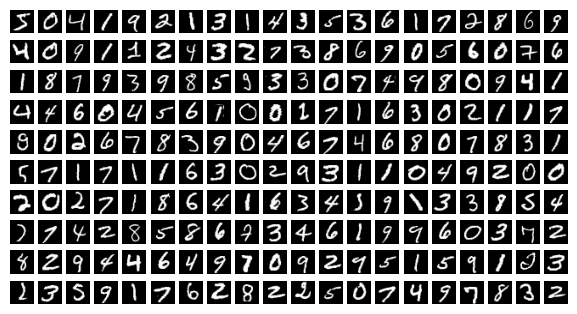

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()

### Quel est l’espace dans lequel se trouvent les images ? Quel est sa taille ?

L’espace des images est un espace vectoriel dans lequel chaque pixel correspond à une
composante du vecteur. Les valeurs des pixels sont des nombres réels compris entre 0 et 1,
car les images sont normalisées par la valeur maximale du niveau de gris (255).

Chaque image ayant une résolution de **28 × 28 pixels**, la taille de cet espace est donc : 784

Ainsi, chaque image est représentée par un vecteur de **784 dimensions**.


# Exercice 1 : Régression Logistique

### Nombre de paramètres du modèle

Le modèle est une régression logistique pour la classification MNIST avec **10 classes** et des
images d’entrée de taille **784**.

- La matrice des poids **W** contient un vecteur de poids de taille 784 pour chaque classe :  
  784 × 10 = 7840 paramètres.
- Le vecteur de biais **b** contient un biais par classe :  
  10 paramètres.

**Nombre total de paramètres :**  
7840 + 10 = **7850 paramètres**.

### Fonction De Coût
La fonction de coût est définie comme :
$$
L(W,b) = -\frac{1}{N} \sum_{i=1}^{N} \log(\hat{y}_{c^*,i})
$$

Cela peut être reformulé comme :
$$
-\langle x_i, w_{c^*} \rangle - b_{c^*}
+ \log\left(\sum_{c=1}^{10} \exp(\langle x_i, w_c \rangle + b_c)\right)
$$

Le premier terme est **linéaire** par rapport aux paramètres $W$ et $b$, et le second
terme est une **fonction convexe** car il s’agit du logarithme d’une somme
d’exponentielles.

La fonction de coût étant la somme d’une fonction linéaire et d’une fonction convexe,
elle est donc **convexe** par rapport à $W$ et $b$.

Ainsi, avec un **pas de gradient bien choisi**, on peut assurer la convergence vers le
**minimum global** de la solution.




On part de la fonction de coût pour un exemple $i$ :  
$$
L_i = - \sum_{c=1}^{10} y^*_{c,i} \log(\hat{y}_{c,i})
$$
avec la sortie softmax :
$$
\hat{y}_{c,i} = \frac{\exp(s_{c,i})}{\sum_{k=1}^{10} \exp(s_{k,i})}
$$

### Étape 1 : dérivée de la perte par rapport à $\hat{y}_{c,i}$
$$
\frac{\partial L_i}{\partial \hat{y}_{c,i}} = - \frac{y^*_{c,i}}{\hat{y}_{c,i}}
$$

### Étape 2 : dérivée de $\hat{y}_{c,i}$ par rapport à $s_{k,i}$
Pour le softmax, on a :
$$
\frac{\partial \hat{y}_{c,i}}{\partial s_{k,i}} =
\begin{cases}
\hat{y}_{c,i}(1-\hat{y}_{c,i}) & \text{si } k = c\\
-\hat{y}_{c,i}\hat{y}_{k,i} & \text{si } k \neq c
\end{cases}
$$

### Étape 3 : règle de la chaîne
En combinant les deux dérivées :
$$
\frac{\partial L_i}{\partial s_{c,i}}
= \sum_{k=1}^{10} \frac{\partial L_i}{\partial \hat{y}_{k,i}} \frac{\partial \hat{y}_{k,i}}{\partial s_{c,i}}
= \hat{y}_{c,i} - y^*_{c,i}
$$

### Résultat vectoriel
Pour tout l’exemple $i$ :
$$
\frac{\partial L_i}{\partial s_i} = \delta y_i = \hat{y}_i - y^*_i
$$

Ainsi, la dérivée de la perte par rapport aux scores $s_i$ est simplement la différence
entre la prédiction softmax et le vecteur « one-hot » de la classe réelle.


### Les gradients de L par rapport aux paramètres du modèle
On a montré que pour chaque exemple $i$ :  
$$
\frac{\partial L_i}{\partial s_i} = \delta y_i = \hat{y}_i - y^*_i
$$

Or $s_i = x_i W + b$, donc en appliquant la règle de la chaîne :

- Pour les poids $W$ :  
$$
\frac{\partial L}{\partial W} = \frac{1}{N} \sum_{i=1}^{N} x_i^T \delta y_i
$$
ou en notation matricielle :
$$
\frac{\partial L}{\partial W} = \frac{1}{N} X^T (\hat{Y} - Y^*) = \frac{1}{N} X^T \Delta y
$$

- Pour les biais $b$ :  
$$
\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} \delta y_i
= \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y^*_i)
$$

Ainsi, les gradients sont directement exprimés en fonction de la différence entre les
prédictions et les labels réels.


In [ ]:
def softmax(X):
 # Input matrix X of size Nbxd - Output matrix of same size
 E = np.exp(X)
 return (E.T / np.sum(E,axis=1)).T

def forward(batch, W,b):
  return softmax(batch @ W + b)

def accuracy(W, b, images, labels):
  pred = forward(images, W,b )
  return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

In [ ]:
from tensorflow.keras.utils import to_categorical


# Weight matrix
W = np.random.rand(784, 10)

# Bias
b = np.random.rand(10)
W.shape, b.shape


K=10
# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, K)
Y_test = to_categorical(y_test, K)

In [ ]:
N = X_train.shape[0]
d = X_train.shape[1]
W = np.zeros((d,K))
b = np.zeros((1,K))
numEp = 20 # Number of epochs for gradient descent
eta = 1e-1 # Learning rate
batch_size = 100
nb_batches = int(float(N) / batch_size)
gradW = np.zeros((d,K))
gradb = np.zeros((1,K))

for epoch in range(numEp):
  for ex in range(nb_batches):
    start = ex * batch_size
    end = batch_size * ( ex + 1)
    X_batch = X_train[start:end]
    y_true_batch = Y_train[start:end]
    y_prd_batch = forward(X_batch ,W, b)
    delta = y_prd_batch - y_true_batch
    gradW = np.dot(X_batch.T, delta) / batch_size
    gradb = (np.sum(delta, axis=0, keepdims=True)) / batch_size
    W = W - eta * gradW
    b = b -eta * gradb

  print(f"Epoch: {epoch} | Training Acc: {accuracy(W,b, X_train, Y_train)} | Test Acc: {accuracy( W,b, X_test, Y_test)}")


Epoch: 0 | Training Acc: 89.27333333333334 | Test Acc: 90.24
Epoch: 1 | Training Acc: 90.33 | Test Acc: 90.91
Epoch: 2 | Training Acc: 90.92833333333333 | Test Acc: 91.36999999999999
Epoch: 3 | Training Acc: 91.25333333333333 | Test Acc: 91.60000000000001
Epoch: 4 | Training Acc: 91.45333333333333 | Test Acc: 91.7
Epoch: 5 | Training Acc: 91.62333333333333 | Test Acc: 91.81
Epoch: 6 | Training Acc: 91.74833333333333 | Test Acc: 91.86999999999999
Epoch: 7 | Training Acc: 91.85 | Test Acc: 91.95
Epoch: 8 | Training Acc: 91.96 | Test Acc: 92.04
Epoch: 9 | Training Acc: 92.035 | Test Acc: 92.04
Epoch: 10 | Training Acc: 92.09 | Test Acc: 92.13
Epoch: 11 | Training Acc: 92.17333333333333 | Test Acc: 92.14
Epoch: 12 | Training Acc: 92.23333333333333 | Test Acc: 92.15
Epoch: 13 | Training Acc: 92.25999999999999 | Test Acc: 92.15
Epoch: 14 | Training Acc: 92.31166666666667 | Test Acc: 92.21000000000001
Epoch: 15 | Training Acc: 92.36666666666666 | Test Acc: 92.22
Epoch: 16 | Training Acc: 92.4

# Exercice 2 : Perceptron multi-couches (MLP)

Dans un **Perceptron multicouche (MLP)** avec au moins une couche cachée, la fonction de coût est **non convexe**.  

Cela signifie qu’il peut exister **plusieurs minima locaux** au lieu d’un seul minimum global.  
En pratique, même avec un **pas de gradient bien choisi**, l’algorithme de descente de gradient peut **converger vers un minimum local** plutôt que vers le minimum global, ce qui peut entraîner des **performances sous-optimales**.  

Cette non-convexité rend également **difficile de garantir la convergence** vers une solution optimale.  
C’est un inconvénient important des MLP et autres modèles non convexes, car elle **limite leur capacité à trouver la solution globale optimale** pour le problème à résoudre.


In [ ]:
def softmax(X):
 # Input matrix X of size Nbxd - Output matrix of same size
 E = np.exp(X)
 return (E.T / np.sum(E,axis=1)).T

def sigmoid(X):
  return (1/ (1 + np.exp(-X)))

def mlp_forward(batch, Wh,bh, Wy, by):
  hidden_layer = sigmoid(batch @ Wh + bh)
  prediction = softmax(hidden_layer @ Wy + by)
  return hidden_layer, prediction

def mlp_accuracy(images, labels, Wh, bh, Wy, by):
  _ , pred = mlp_forward(images, Wh, bh, Wy, by)
  return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

## Weight initialization with zeros

En initialisant toutes les matrices de poids et les biais à **0**, les performances du MLP
restent limitées.  

Le **taux de précision maximal obtenu** sur le jeu de test est d’environ **65 %**.  

On peut en conclure que l’**initialisation à zéro est inadaptée pour un MLP** : tous les
neurones de la couche cachée reçoivent les mêmes gradients et restent identiques pendant
l’apprentissage, ce qui empêche le réseau d’apprendre des représentations efficaces.


Epoch  20 | Loss: 1.0064 | Train Acc: 64.6250 | Test Acc: 64.4100
Epoch  40 | Loss: 1.0121 | Train Acc: 64.8000 | Test Acc: 64.4700
Epoch  60 | Loss: 1.0111 | Train Acc: 64.8783 | Test Acc: 64.4600
Epoch  80 | Loss: 1.0135 | Train Acc: 64.6450 | Test Acc: 64.1000
Epoch 100 | Loss: 1.0181 | Train Acc: 64.4183 | Test Acc: 63.9600


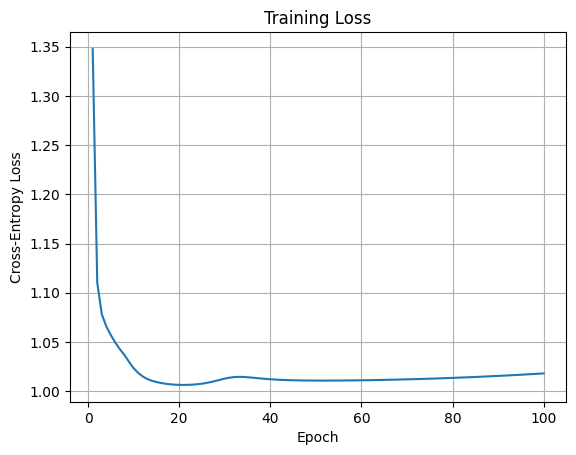

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mlp_forward and mlp_accuracy are already defined

N = X_train.shape[0]
D = X_train.shape[1]
K = 10
L = 100
eta = 1
batch_size = 100
epochs = 100
nb_batches = int(N / batch_size)

Wh = np.zeros((D, L))
bh = np.zeros((1, L))
Wy = np.zeros((L, K))
by = np.zeros((1, K))

train_losses = []

for epoch in range(epochs):
    for batch in range(nb_batches):
        start = batch_size * batch
        end = batch_size * (batch + 1)
        X_batch = X_train[start:end]
        y_true_batch = Y_train[start:end]

        H, y_prd_batch = mlp_forward(X_batch, Wh, bh, Wy, by)
        delta_y = y_prd_batch - y_true_batch
        delta_h = (delta_y @ Wy.T) * H * (1 - H)

        gradWh = (X_batch.T @ delta_h) / batch_size
        gradbh = np.sum(delta_h, axis=0, keepdims=True) / batch_size
        gradWy = (H.T @ delta_y) / batch_size
        gradby = np.sum(delta_y, axis=0, keepdims=True) / batch_size

        Wh -= eta * gradWh
        bh -= eta * gradbh
        Wy -= eta * gradWy
        by -= eta * gradby

    _, y_pred_full = mlp_forward(X_train, Wh, bh, Wy, by)
    loss = -np.mean(np.sum(Y_train * np.log(y_pred_full + 1e-15), axis=1))
    train_losses.append(loss)

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        train_acc = mlp_accuracy(X_train, Y_train, Wh, bh, Wy, by)
        test_acc = mlp_accuracy(X_test, Y_test, Wh, bh, Wy, by)
        print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

## Random weight initialization with normale destribution (0 mean, 0.1 std)

Epoch  20 | Loss: 0.0360 | Train Acc: 99.0233 | Test Acc: 97.1800
Epoch  40 | Loss: 0.0124 | Train Acc: 99.8317 | Test Acc: 97.5200
Epoch  60 | Loss: 0.0059 | Train Acc: 99.9667 | Test Acc: 97.5500
Epoch  80 | Loss: 0.0036 | Train Acc: 99.9933 | Test Acc: 97.5600
Epoch 100 | Loss: 0.0024 | Train Acc: 99.9983 | Test Acc: 97.5400


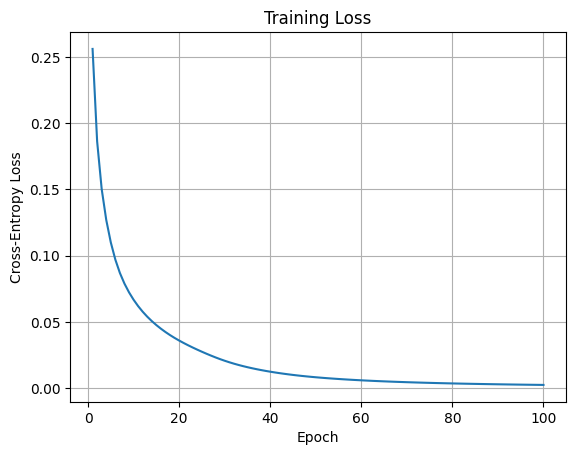

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = X_train.shape[0]
D = X_train.shape[1]
K = 10
L = 100
eta = 1
batch_size = 100
epochs = 100
nb_batches = int(N / batch_size)

Wh = np.random.rand(D, L) * 0.1
bh = np.random.rand(1, L) * 0.1
Wy = np.random.rand(L, K) * 0.1
by = np.random.rand(1, K) * 0.1

train_losses = []

for epoch in range(epochs):
    for batch in range(nb_batches):
        start = batch_size * batch
        end = batch_size * (batch + 1)
        X_batch = X_train[start:end]
        y_true_batch = Y_train[start:end]

        H, y_prd_batch = mlp_forward(X_batch, Wh, bh, Wy, by)
        delta_y = y_prd_batch - y_true_batch
        delta_h = (delta_y @ Wy.T) * H * (1 - H)

        gradWh = (X_batch.T @ delta_h) / batch_size
        gradbh = np.sum(delta_h, axis=0, keepdims=True) / batch_size
        gradWy = (H.T @ delta_y) / batch_size
        gradby = np.sum(delta_y, axis=0, keepdims=True) / batch_size

        Wh -= eta * gradWh
        bh -= eta * gradbh
        Wy -= eta * gradWy
        by -= eta * gradby

    _, y_pred_full = mlp_forward(X_train, Wh, bh, Wy, by)
    loss = -np.mean(np.sum(Y_train * np.log(y_pred_full + 1e-15), axis=1))
    train_losses.append(loss)

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        train_acc = mlp_accuracy(X_train, Y_train, Wh, bh, Wy, by)
        test_acc = mlp_accuracy(X_test, Y_test, Wh, bh, Wy, by)
        print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# Xavier initialisation

Epoch  20 | Loss: 0.0315 | Train Acc: 99.2100 | Test Acc: 97.5100
Epoch  40 | Loss: 0.0112 | Train Acc: 99.8700 | Test Acc: 97.6800
Epoch  60 | Loss: 0.0054 | Train Acc: 99.9850 | Test Acc: 97.6800
Epoch  80 | Loss: 0.0032 | Train Acc: 100.0000 | Test Acc: 97.6500
Epoch 100 | Loss: 0.0022 | Train Acc: 100.0000 | Test Acc: 97.7300


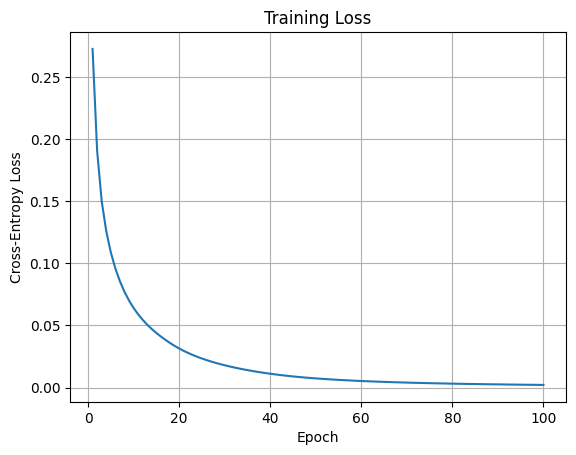

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = X_train.shape[0]
D = X_train.shape[1]
K = 10
L = 100
eta = 1
batch_size = 100
epochs = 100
nb_batches = int(N / batch_size)

Wh = np.random.rand(D, L) / np.sqrt(D)
bh = np.random.rand(1, L) / np.sqrt(D)
Wy = np.random.rand(L, K) / np.sqrt(L)
by = np.random.rand(1, K) / np.sqrt(L)

train_losses = []

for epoch in range(epochs):
    for batch in range(nb_batches):
        start = batch_size * batch
        end = batch_size * (batch + 1)
        X_batch = X_train[start:end]
        y_true_batch = Y_train[start:end]

        H, y_prd_batch = mlp_forward(X_batch, Wh, bh, Wy, by)
        delta_y = y_prd_batch - y_true_batch
        delta_h = (delta_y @ Wy.T) * H * (1 - H)

        gradWh = (X_batch.T @ delta_h) / batch_size
        gradbh = np.sum(delta_h, axis=0, keepdims=True) / batch_size
        gradWy = (H.T @ delta_y) / batch_size
        gradby = np.sum(delta_y, axis=0, keepdims=True) / batch_size

        Wh -= eta * gradWh
        bh -= eta * gradbh
        Wy -= eta * gradWy
        by -= eta * gradby

    _, y_pred_full = mlp_forward(X_train, Wh, bh, Wy, by)
    loss = -np.mean(np.sum(Y_train * np.log(y_pred_full + 1e-15), axis=1))
    train_losses.append(loss)

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        train_acc = mlp_accuracy(X_train, Y_train, Wh, bh, Wy, by)
        test_acc = mlp_accuracy(X_test, Y_test, Wh, bh, Wy, by)
        print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

En testant deux autres initialisations des poids :

- **Initialisation aléatoire normale** avec moyenne 0 et écart type 0.1  
- **Initialisation Xavier**, qui adapte la variance en fonction du nombre de neurones d’entrée

les performances du MLP s’améliorent considérablement.  

Le **taux de précision obtenu** sur le jeu de test atteint **environ 98 %**, avec
l’initialisation **Xavier** qui permet **une convergence beaucoup plus rapide** que
l’initialisation aléatoire simple.  

On en conclut que **le choix de l’initialisation des poids est crucial** pour l’apprentissage
des MLP, car il influence à la fois la vitesse de convergence et la performance finale.
